# Reconstruction the XCT data using 3 algorithms

## Python imports

In [1]:
%matplotlib inline

import copy, math
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

from IPython.display import display

import itk

from skimage.transform import iradon
from scipy import ndimage

import tigre
from tigre.utilities import sample_loader
from tigre.utilities import CTnoise
import tigre.algorithms as algs

import tomopy
import dxchange

## Global variables

In [2]:
pixel_spacing_in_micrometre = 1.9;
pixel_spacing_in_mm = pixel_spacing_in_micrometre * 1e-3;
number_of_projections = 900;
angular_span_in_degrees = 180.0;
angular_step = angular_span_in_degrees / number_of_projections;
theta_deg = np.linspace(0.,
                    angular_span_in_degrees,
                    number_of_projections,
                    endpoint=False);
theta_rad = theta_deg / 180.0 * math.pi;

## Loading the projetions

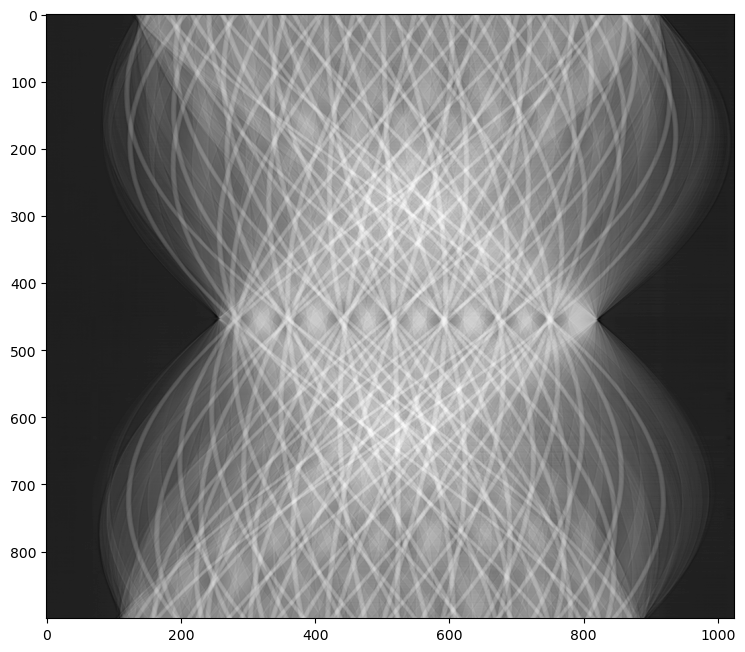

In [3]:
CPUImageType = itk.Image[itk.F,3]

reference_normalised_projections = np.fromfile("sino.raw", dtype=np.float32);
reference_normalised_projections.shape = [
    number_of_projections,
    1, 
    int(reference_normalised_projections.shape[0] / number_of_projections)
];

# projections = tomopy.minus_log(reference_normalised_projections)
projections = -np.log(reference_normalised_projections);
# projections /= 0.00019

geo = tigre.geometry_default()
geo.mode = "cone"  # Or 'parallel'. Geometry type.
geo.DSD = 140 * 1000 + 80  # Distance Source Detector      (mm)
geo.DSO = 140 * 1000  # Distance Source Origin        (mm)

geo.nDetector = np.array([1, 1024])
geo.dDetector = np.array([pixel_spacing_in_mm, pixel_spacing_in_mm])
geo.sDetector = geo.nDetector * geo.dDetector  # total size of the detector    (mm)

geo.nVoxel = np.array([1, 1024, 1024])
geo.dVoxel = np.array([pixel_spacing_in_mm, pixel_spacing_in_mm, pixel_spacing_in_mm])
geo.sVoxel = geo.nVoxel * geo.dVoxel  # total size of the detector    (mm)

plt.imshow(projections[:, 0, :], cmap="gray")

## CERN's Tigre -- FDK

See [https://github.com/CERN/TIGRE](https://github.com/CERN/TIGRE)

Writing output image...


Text(0.5, 1.0, "Tigre's FDK")

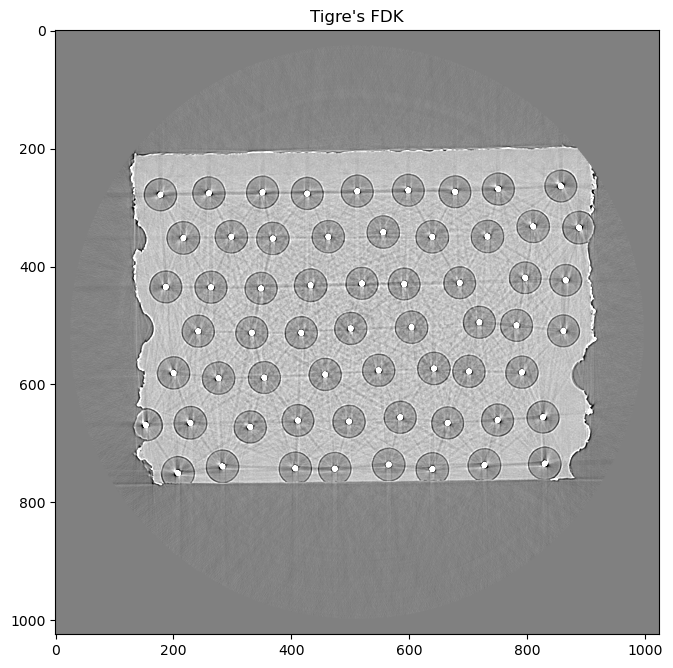

In [4]:
# FDK
start_time = time.time()
imgFDK = algs.fdk(projections, geo, theta_rad, filter="shepp_logan")
fdk_tigre_time = time.time() - start_time

recons = []
for slice in range(imgFDK.shape[0]):
    recons.append(imgFDK[slice].T)

fdk_tigre_recons = np.array(recons)
fdk_tigre_recons *= 10; # To rescale in cm-1

fdk_tigre_recons = tomopy.circ_mask(fdk_tigre_recons, axis=0, ratio=0.95)

print("Writing output image...")
WriterType = itk.ImageFileWriter[CPUImageType]
writer = WriterType.New();
writer.SetFileName("fdk_tigre_recons.mha");
writer.SetInput(itk.GetImageFromArray(fdk_tigre_recons));
writer.Update();

#%% Show the results
norm = cm.colors.Normalize(vmax=25, vmin=-25)
plt.imshow(fdk_tigre_recons[0], cmap="gray", norm=norm)
plt.title("Tigre's FDK")

## Tomopy -- Gridrec

See [https://tomopy.readthedocs.io/en/latest/ipynb/tomopy.html](https://tomopy.readthedocs.io/en/latest/ipynb/tomopy.html)

Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
Reconstruc

Text(0.5, 1.0, "Tomopy's gridrec")

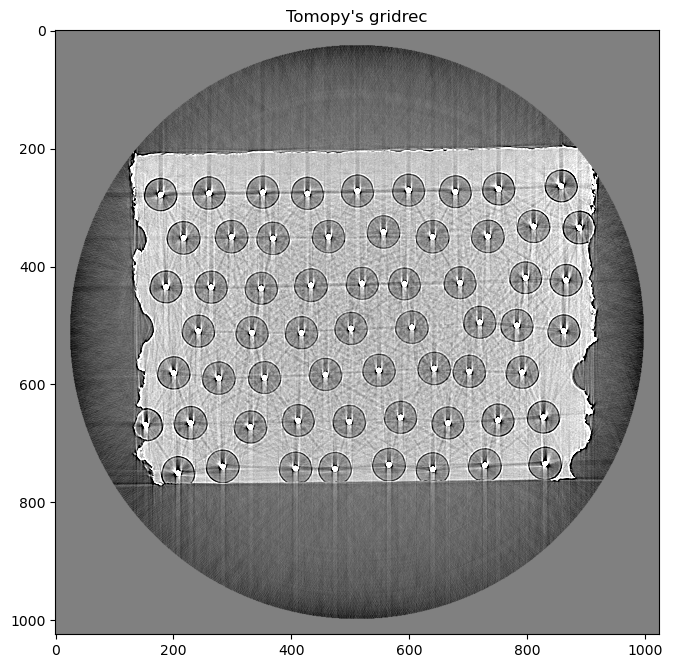

In [5]:
rot_center = tomopy.find_center(projections, theta_rad, init=512, ind=0, tol=0.5)

start_time = time.time()
gridrec_tomopy_recons = tomopy.recon(projections, theta_rad, center=rot_center, algorithm='gridrec', sinogram_order=False, filter_name='shepp')
gridrec_tomopy_time = time.time() - start_time

gridrec_tomopy_recons /= pixel_spacing_in_mm; # To rescale in cm-1
gridrec_tomopy_recons *= 10; # To rescale in cm-1

gridrec_tomopy_recons = tomopy.circ_mask(gridrec_tomopy_recons, axis=0, ratio=0.95)

print("Writing output image...")
WriterType = itk.ImageFileWriter[CPUImageType]
writer = WriterType.New();
writer.SetFileName("gridrec_tomopy_recons.mha");
writer.SetInput(itk.GetImageFromArray(gridrec_tomopy_recons));
writer.Update();

plt.imshow(gridrec_tomopy_recons[0, :, :], cmap="gray", norm=norm)
plt.title("Tomopy's gridrec")

## Scikit-image -- FBP

see: [https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.iradon](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.iradon)

Writing output image...


Text(0.5, 1.0, "Scipy's FBP")

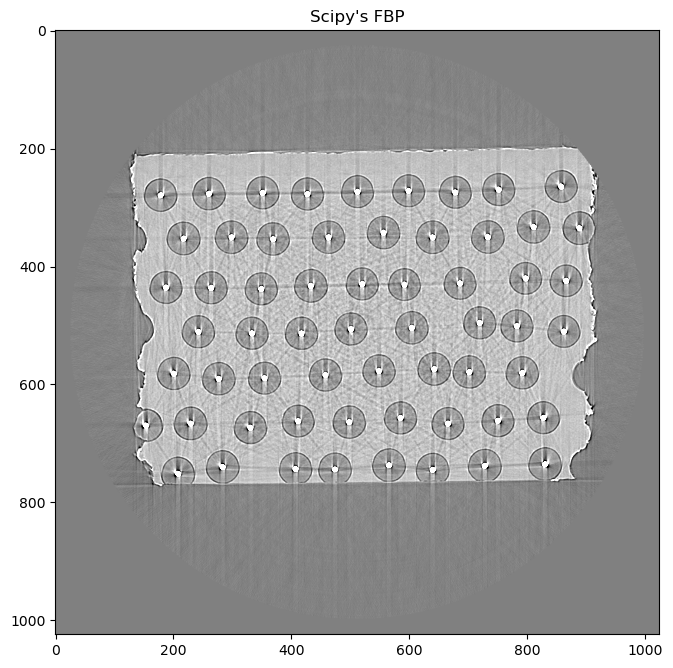

In [6]:
start_time = time.time()
fbp_scipy_recons = iradon(projections[:,0,:].T, theta=theta_deg, filter_name='shepp-logan')
fbp_scipy_time = time.time() - start_time

temp = [];
temp.append(fbp_scipy_recons)
fbp_scipy_recons = np.array(temp)

fbp_scipy_recons /= pixel_spacing_in_mm; # To rescale in cm-1
fbp_scipy_recons *= 10; # To rescale in cm-1

fbp_scipy_recons = tomopy.circ_mask(fbp_scipy_recons, axis=0, ratio=0.95)


print("Writing output image...")
WriterType = itk.ImageFileWriter[CPUImageType]
writer = WriterType.New();
writer.SetFileName("fbp_scipy_recons.mha");
writer.SetInput(itk.GetImageFromArray(fbp_scipy_recons));
writer.Update();

plt.imshow(fbp_scipy_recons[0], cmap="gray", norm=norm)
plt.title("Scipy's FBP")

## Comparison of the CT slices

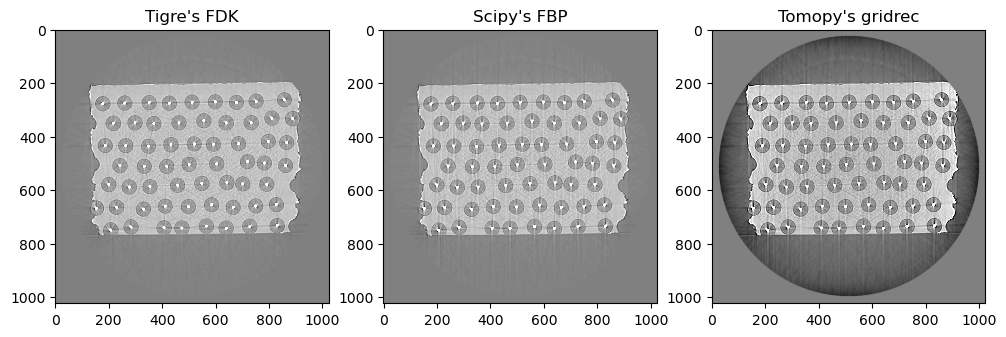

In [7]:
plt.figure();

plt.subplot(1, 3, 1)
plt.title("Tigre's FDK")
plt.imshow(fdk_tigre_recons[0], cmap="gray", norm=norm)

plt.subplot(1, 3, 2)
plt.title("Scipy's FBP")
plt.imshow(fbp_scipy_recons[0], cmap="gray", norm=norm)

plt.subplot(1, 3, 3)
plt.title("Tomopy's gridrec")
plt.imshow(gridrec_tomopy_recons[0], cmap="gray", norm=norm)

## Image statistics (whole CT slices)

In [8]:
data = [];
data.append(["FDK", "Tigre", np.min(fdk_tigre_recons[0]), np.mean(fdk_tigre_recons[0]), np.max(fdk_tigre_recons[0]), np.std(fdk_tigre_recons[0]), fdk_tigre_time]);
data.append(["FBP", "Scipy", np.min(fbp_scipy_recons[0]), np.mean(fbp_scipy_recons[0]), np.max(fbp_scipy_recons[0]), np.std(fbp_scipy_recons[0]), fbp_scipy_time]);
data.append(["gridrec", "Tomopy", np.min(gridrec_tomopy_recons[0]), np.mean(gridrec_tomopy_recons[0]), np.max(gridrec_tomopy_recons[0]), np.std(gridrec_tomopy_recons[0]), gridrec_tomopy_time]);

df = pd.DataFrame(columns=["Algorithm", "Implementation", "Min", "Mean", "Max", "stddev", "seconds"], data=data)
display(df)

,Algorithm,Implementation,Min,Mean,Max,stddev,seconds
0,FDK,Tigre,-62.147301,4.809825,207.966858,11.250696,0.260577
1,FBP,Scipy,-65.148651,4.812399,210.360382,11.249941,7.981715
2,gridrec,Tomopy,-153.755707,2.521870,409.906433,16.571344,0.041801


## Extracting the fibre in the centre of the CT slices

(-60.382171630859375, 222.5867919921875)

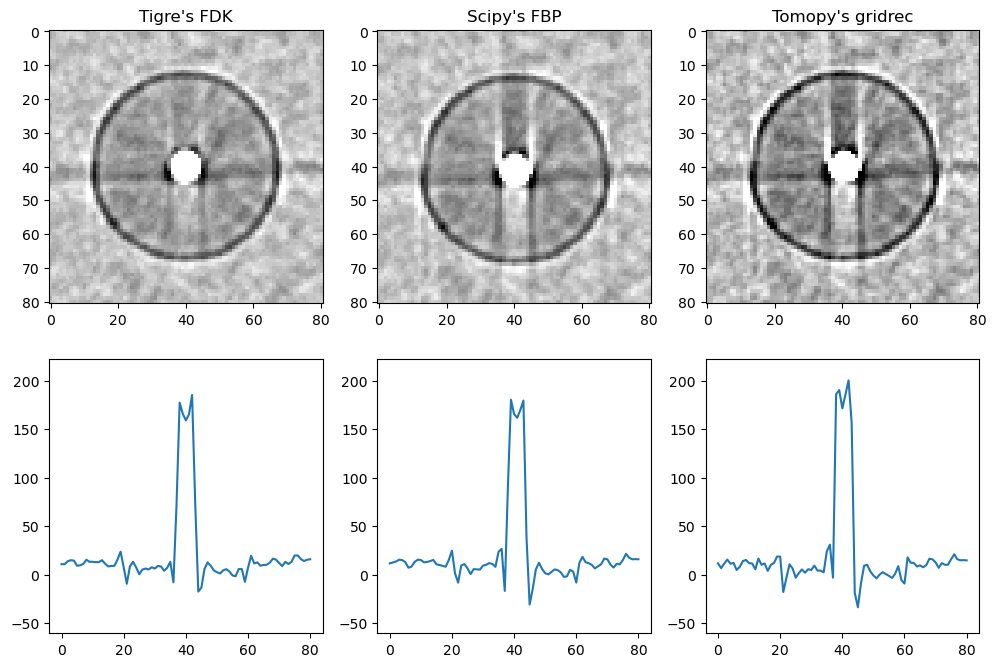

In [9]:
roi_length = 40

fdk_tigre_recons_fibre = fdk_tigre_recons[0][429 - roi_length:430 + roi_length, 520 - roi_length:521 + roi_length];
fbp_scipy_recons_fibre = fbp_scipy_recons[0][429 - roi_length:430 + roi_length, 520 - roi_length:521 + roi_length];
gridrec_tomopy_recons_fibre = gridrec_tomopy_recons[0][429 - roi_length:430 + roi_length, 520 - roi_length:521 + roi_length];

plt.figure();

plt.subplot(2, 3, 1)
plt.title("Tigre's FDK")
plt.imshow(fdk_tigre_recons_fibre, cmap="gray", norm=norm)

plt.subplot(2, 3, 2)
plt.title("Scipy's FBP")
plt.imshow(fbp_scipy_recons_fibre, cmap="gray", norm=norm)

plt.subplot(2, 3, 3)
plt.title("Tomopy's gridrec")
plt.imshow(gridrec_tomopy_recons_fibre, cmap="gray", norm=norm)

min_y = min(min(fdk_tigre_recons_fibre.min(), fbp_scipy_recons_fibre.min()), gridrec_tomopy_recons_fibre.min())
max_y = max(max(fdk_tigre_recons_fibre.max(), fbp_scipy_recons_fibre.max()), gridrec_tomopy_recons_fibre.max())

plt.subplot(2, 3, 4)
plt.plot(np.diag(fdk_tigre_recons_fibre))
plt.ylim(min_y, max_y)

plt.subplot(2, 3, 5)
plt.plot(np.diag(fbp_scipy_recons_fibre))
plt.ylim(min_y, max_y)

plt.subplot(2, 3, 6)
plt.plot(np.diag(gridrec_tomopy_recons_fibre))
plt.ylim(min_y, max_y)

## Extracting the structures of the fibres

### Creating binary masks

In [10]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return np.array(mask, dtype=bool);

In [11]:
def createMasks(mask_shape):
    fibre_radius_in_px = int(108 / pixel_spacing_in_micrometre) / 2
    core_radius_in_px = int(16 / pixel_spacing_in_micrometre) / 2

    core_mask = create_circular_mask(mask_shape[1], mask_shape[0], None, core_radius_in_px);

    fibre_mask = create_circular_mask(mask_shape[1], mask_shape[0], None, fibre_radius_in_px);
    matrix_mask = np.logical_not(fibre_mask);

    #fibre_mask = np.subtract(fibre_mask, core_mask);
    fibre_mask = np.bitwise_xor(fibre_mask, core_mask);

    #TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

    return core_mask, fibre_mask, matrix_mask

In [12]:
mask_shape = fdk_tigre_recons_fibre.shape;
core_mask, fibre_mask, matrix_mask = createMasks(mask_shape);

core_mask = ndimage.binary_erosion(core_mask).astype(core_mask.dtype);

for i in range(4):
    fibre_mask = ndimage.binary_erosion(fibre_mask).astype(fibre_mask.dtype);
    matrix_mask = ndimage.binary_erosion(matrix_mask, border_value=1).astype(matrix_mask.dtype);

core_mask.shape = [core_mask.shape[0], core_mask.shape[1]]
fibre_mask.shape = [fibre_mask.shape[0], fibre_mask.shape[1]]
matrix_mask.shape = [matrix_mask.shape[0], matrix_mask.shape[1]]

### Displaying the binary masks

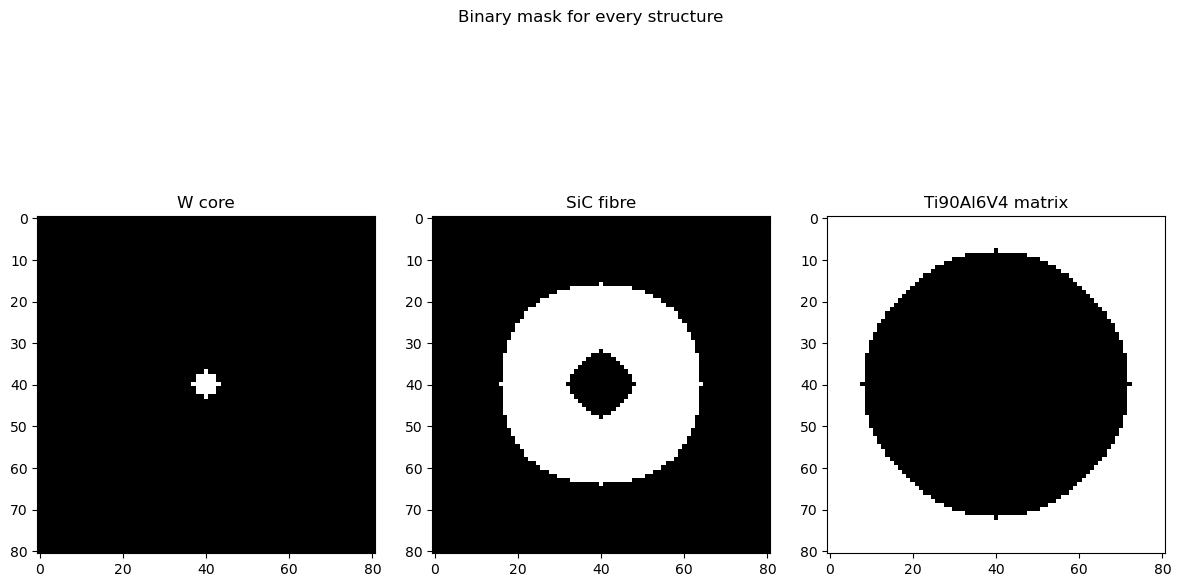

In [13]:
norm = cm.colors.Normalize(vmax=1, vmin=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.tight_layout()
fig.suptitle('Binary mask for every structure')

ax1.set_title("W core");
imgplot1 = ax1.imshow(core_mask, cmap="gray", 
                     norm=norm);

ax2.set_title("SiC fibre");
imgplot2 = ax2.imshow(fibre_mask,
                     cmap='gray',
                     norm=norm);

ax3.set_title("Ti90Al6V4 matrix");
imgplot3 = ax3.imshow(matrix_mask,
                     cmap='gray',
                     norm=norm);

### Extracting the $\mu$ statistics per structure per reconstruction

In [14]:
def getMuStatistics(fdk_tigre_recons_fibre, fbp_scipy_recons_fibre, gridrec_tomopy_recons_fibre, core_mask, fibre_mask, matrix_mask):

    data = [];
    
    index = np.nonzero(core_mask);
    data.append(["Theorical", 
            "",
            "Core", 
            "W", 
            341.61,
            341.61,
            341.61,
            0.0]);

    data.append(["FDK", 
            "Tigre",
            "Core", 
            "W", 
            np.min(fdk_tigre_recons_fibre[index]),
            np.max(fdk_tigre_recons_fibre[index]),
            np.mean(fdk_tigre_recons_fibre[index]),
            np.std(fdk_tigre_recons_fibre[index])]);

    data.append(["FBP", 
            "Scipy",
            "Core", 
            "W", 
            np.min(fbp_scipy_recons_fibre[index]),
            np.max(fbp_scipy_recons_fibre[index]),
            np.mean(fbp_scipy_recons_fibre[index]),
            np.std(fbp_scipy_recons_fibre[index])]);

    data.append(["gridrec", 
            "Tomopy",
            "Core", 
            "W", 
            np.min(gridrec_tomopy_recons_fibre[index]),
            np.max(gridrec_tomopy_recons_fibre[index]),
            np.mean(gridrec_tomopy_recons_fibre[index]),
            np.std(gridrec_tomopy_recons_fibre[index])]);

    index = np.nonzero(fibre_mask);

    data.append(["Theorical", 
            "",
            "Fibre", 
            "SiC", 
            2.736,
            2.736,
            2.736,
            0.0]);
    
    data.append(["FDK", 
            "Tigre",
            "Fibre", 
            "SiC", 
            np.min(fdk_tigre_recons_fibre[index]),
            np.max(fdk_tigre_recons_fibre[index]),
            np.mean(fdk_tigre_recons_fibre[index]),
            np.std(fdk_tigre_recons_fibre[index])]);

    data.append(["FBP", 
            "Scipy",
            "Fibre", 
            "SiC", 
            np.min(fbp_scipy_recons_fibre[index]),
            np.max(fbp_scipy_recons_fibre[index]),
            np.mean(fbp_scipy_recons_fibre[index]),
            np.std(fbp_scipy_recons_fibre[index])]);

    data.append(["gridrec", 
            "Tomopy",
            "Fibre", 
            "SiC", 
            np.min(gridrec_tomopy_recons_fibre[index]),
            np.max(gridrec_tomopy_recons_fibre[index]),
            np.mean(gridrec_tomopy_recons_fibre[index]),
            np.std(gridrec_tomopy_recons_fibre[index])]);

    index = np.nonzero(matrix_mask);
    data.append(["Theorical", 
            "",
            "Matrix", 
            "Ti90Al6V4", 
            13.1274,
            13.1274,
            13.1274,
            0.0]);

    data.append(["FDK", 
            "Tigre",
            "Matrix", 
                "Ti90Al6V4", 
            np.min(fdk_tigre_recons_fibre[index]),
            np.max(fdk_tigre_recons_fibre[index]),
            np.mean(fdk_tigre_recons_fibre[index]),
            np.std(fdk_tigre_recons_fibre[index])]);

    data.append(["FBP", 
            "Scipy",
            "Matrix", 
            "Ti90Al6V4", 
            np.min(fbp_scipy_recons_fibre[index]),
            np.max(fbp_scipy_recons_fibre[index]),
            np.mean(fbp_scipy_recons_fibre[index]),
            np.std(fbp_scipy_recons_fibre[index])]);

    data.append(["gridrec", 
            "Tomopy",
            "Matrix", 
            "Ti90Al6V4", 
            np.min(gridrec_tomopy_recons_fibre[index]),
            np.max(gridrec_tomopy_recons_fibre[index]),
            np.mean(gridrec_tomopy_recons_fibre[index]),
            np.std(gridrec_tomopy_recons_fibre[index])]);
    
    return pd.DataFrame(data,
            index=None,
            columns=["Algorithm", "Implementation", 'Structure', "Composition", 'min', 'max', 'mean', 'stddev'])

In [15]:
df = getMuStatistics(fdk_tigre_recons_fibre, fbp_scipy_recons_fibre, gridrec_tomopy_recons_fibre, core_mask, fibre_mask, matrix_mask)
display(df)

,Algorithm,Implementation,Structure,Composition,min,max,mean,stddev
0,Theorical,,Core,W,341.610000,341.610000,341.610000,0.000000
1,FDK,Tigre,Core,W,159.063141,185.235764,173.700867,7.411725
2,FBP,Scipy,Core,W,89.593781,181.560776,162.344254,21.667259
3,gridrec,Tomopy,Core,W,171.415833,222.586792,193.842392,10.924818
4,Theorical,,Fibre,SiC,2.736000,2.736000,2.736000,0.000000
5,FDK,Tigre,Fibre,SiC,-13.260770,20.615225,5.665313,4.083169
6,FBP,Scipy,Fibre,SiC,-33.707584,28.980541,5.610079,5.730170
7,gridrec,Tomopy,Fibre,SiC,-33.603771,33.350952,3.271451,6.651147
8,Theorical,,Matrix,Ti90Al6V4,13.127400,13.127400,13.127400,0.000000
9,FDK,Tigre,Matrix,Ti90Al6V4,0.479040,23.464678,12.739101,3.343770
